In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Version of tensorflow should be specified in Colab
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras import datasets, layers, models
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
import pathlib
# Specifying test and training paths
train_dir = pathlib.Path('/home/michael/Downloads/fruits-fresh-and-rotten-for-classification/dataset/train/')
test_dir = pathlib.Path('/home/michael/Downloads/fruits-fresh-and-rotten-for-classification/dataset/test')

In [13]:
image_count = len(list(train_dir.glob('*/*.png'))) + len(list(test_dir.glob('*/*.png')))
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['rottenbanana', 'freshapples', 'rottenoranges', 'rottenapples',
       'freshoranges', 'freshbanana'], dtype='<U13')

In [14]:
# The 1./255 is to convert from uint8 to float32 in range [0,1]. Split data into 80/20 
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# The transformations shear_range, zoom_range, horizontal_flip will improve accuracy across data and allow for more generalized inputs
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)
# CONSTANTS, currently unsure what to set IMG_HEIGHT and IMG_WIDTH
BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [15]:

train_data_gen = train_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="sparse",
                                                     classes = list(CLASS_NAMES))
test_data_gen = test_generator.flow_from_directory(directory=str(test_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="sparse",
                                                     classes = list(CLASS_NAMES))

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [16]:
# CNN architecure based on https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/ I used batch normalization before an activation function like selu or relu
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='selu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='selu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='selu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(.5))
model.add(layers.Dense(64, activation='selu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

In [17]:
# Setup checkpoint callback - will save the model after each epoch if validation loss is lower than the previous checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('./', save_best_only=True)

In [18]:
# Compiler
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the data and validating with test data
history = model.fit(
        train_data_gen,
        epochs=25,
        callbacks=[checkpoint],
        validation_data=test_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 171 steps, validate for 43 steps
Epoch 1/25
170/171 [============================>.] - ETA: 0s - loss: 0.8651 - accuracy: 0.7650WARNING:tensorflow:From /home/michael/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./assets
171/171 [==============================] - 148s 866ms/step - loss: 0.8646 - accuracy: 0.7653 - val_loss: 4.6777 - val_accuracy: 0.2676
Epoch 2/25
171/171 [==============================] - 149s 870ms/step - loss: 0.4316 - accuracy: 0.8617 - val_loss: 1.1697 - val_accuracy: 0.6664
Epoch 3/25
171/171 [==============================] - 147s 861ms/step - loss: 0.3166 - accuracy: 0.8915 - val_lo

  ...
    to  
  ['...']
43/43 - 10s - loss: 0.0893 - accuracy: 0.9752


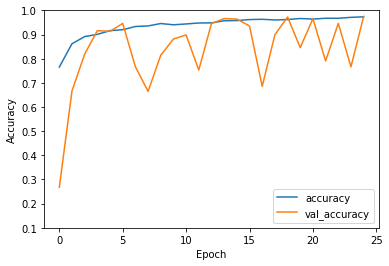

In [19]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)

In [20]:
import base64

def save_model_signed(model, path):
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, ], dtype=tf.string)])
    def preprocess_and_evaluate(b64_img):
        img = tf.image.decode_image(b64_img[0], dtype=tf.uint8)
        img.set_shape((None, None, 3))
        img = tf.image.resize(img, [128, 128])
        img = tf.reshape(img, (-1, 128, 128, 3))
        img = tf.cast(img, dtype=tf.float32) / 255


        return model(img)
    
    tf.saved_model.save(model, path, signatures=preprocess_and_evaluate)

In [21]:
save_model_signed(model,'')

INFO:tensorflow:Assets written to: assets
